In [10]:
from statlib.distributions import Cauchy, Uniform, Pareto
from statlib.rand.engine import LCG
from matplotlib import pyplot as plt
# from ipywidgets import interact, IntSlider, fixed
import numpy as np
import math
from scipy.stats import chi2

plt.style.use('ggplot')

### Создадим генератор случайной величины

In [11]:
gen = LCG()

par = Pareto(gen)
uniform = Uniform(gen)

### Проверим гипотезу равномерности генератора

In [12]:
def build_sample(gen, n):
    return np.array([gen.next() for _ in range(n)], dtype=np.float64)

def find_uniform_distance(val_counts, n):
    return val_counts - 1

In [13]:
def plot_uniform_distributions(gen, iterations):
    uniform_diffs = []
    for n in iterations:
        z = build_sample(gen, n)
        
        val_counts, _, _ = plt.hist(z, density=True)
        
        uniform_diff = find_uniform_distance(val_counts, n)
        uniform_diffs.append(uniform_diff)

        plt.hlines(1, min(z), max(z))
        plt.title('Number of elements: {0}'.format(n))
        plt.show()
    
    return uniform_diffs


def plot_uniform_diffs(uniform_diffs, counts):
    uniform_diffs = np.array(uniform_diffs)
    nbins = len(uniform_diffs[0])
    
    for i in range(nbins):
        histogram_diff = uniform_diffs[:, i]
        plt.plot(counts, histogram_diff, label='Bar #{}'.format(i))
    
    plt.xscale('log')
    plt.ylabel('Difference with 1')
    plt.xlabel('Amount of values')
    plt.legend()
    plt.show()

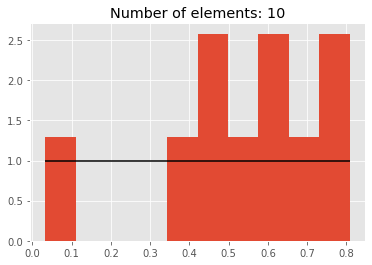

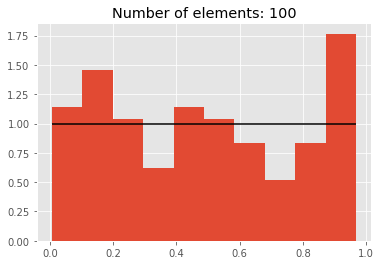

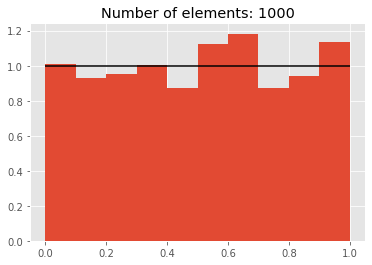

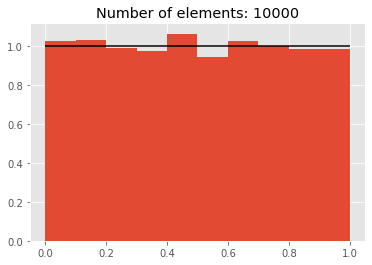

In [14]:
counts = [10, 100, 1000, 10000]
uniform_diffs = plot_uniform_distributions(uniform, counts)

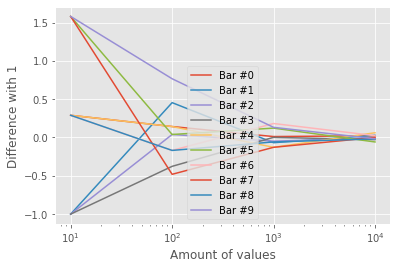

In [15]:
plot_uniform_diffs(uniform_diffs, counts)

### Проверим независимость

In [16]:
def expectation(z):
    return sum(z) / len(z)


def dispersion(z):
    mx = expectation(z)
    return sum((z - mx) ** 2) / (len(z) - 1)


def conditional_expectation(x, y):
    n = len(x)
    return sum(x[i] * y[i] for i in range(n)) / n


def find_covariance(z, n, s=3):
    n = len(z)
    
    mz = expectation(z)
    dz = dispersion(z)
    
    x = [z[i] for i in range(n - s)]
    y = [z[i] for i in range(s, n)]
    mxy = conditional_expectation(x, y)
    
    return (mxy - mz * mz) / dz

In [17]:
for ind_n in [10, 100, 1000, 10000, 100000]:
    z = build_sample(uniform, ind_n)
    covariance = find_covariance(z, ind_n)
    
    print('n: {:6}, r: {}'.format(ind_n, covariance))

n:     10, r: -0.43185000960157865
n:    100, r: -0.23195634029868714
n:   1000, r: -0.004416032441549621
n:  10000, r: 0.021784070491743687
n: 100000, r: 0.005398610912625462


### Проверим стохастичность

In [18]:
def C(n, k):
    return math.factorial(n) / (math.factorial(n - k) * math.factorial(k))

def theor_nj(j, l, N):
    return N * C(l, j) / 2**l

In [53]:
import struct
def binary(num):
    bits = []
    for c in struct.pack('!f', num):
        bits.append(bin(c).replace('0b', '').rjust(8, '0'))
        
    return ''.join(bits)
binary(0.1)

'00111101110011001100110011001101'

In [45]:
def pract_nj(x_var, j):
    ans = 0
    for z in x_var:
        if len(binary(z).replace('0', '')) == j:
            ans += 1
    return ans

In [89]:
len_ = 31

N = 1000
stoh_x_var = build_sample(gen, N)
chi_stoh = 0
for j in range(1, 32):
    p_j = pract_nj(stoh_x_var, j)
    t_j = theor_nj(j, len_, N)
    chi_stoh += (p_j / N - t_j / N)**2 / (t_j / N)
    #print('j = {}, Theor: {}, Pract: {}'.format(j, t_j, p_j))

print(chi2.ppf(0.05, len_ - 1))
print(chi_stoh)

18.49266098195347
0.09036475972062281


#### Начальные параметры для гистограмм

In [22]:
def get_bins_count(n):
    if n <= 100: return int(np.sqrt(n))
    return 4 * int(np.log(n))

n = 10000
segments = get_bins_count(n)

### Распределение Парето

In [23]:
x0 = 1
alpha = 2

In [24]:
def build_pareto_sample(n, x0, alpha):
    return sorted(par.next(x0, alpha) for _ in range(n))


def build_pareto_var(n, x0, alpha):
    ranges = (0, 15)

    x_var = build_pareto_sample(n, x0, alpha)
    x_var = [x for x in x_var if x >= ranges[0] and x <= ranges[1]]
    return np.array(x_var)

In [25]:
x_var = build_pareto_var(n, x0, alpha)
n = len(x_var)

### Равноинтервальная гистограмма

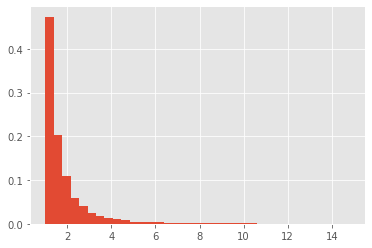

In [26]:
weights = np.ones_like(x_var) / len(x_var)
vals, bins, patches = plt.hist(x_var, bins=segments, weights=weights)

In [27]:
def get_val_counts(arr):
    counts = {}
    for x in arr:
        counts[x] = counts.get(x, 0) + 1
        
    return counts

def build_distribution_function(x_var):
    counts = get_val_counts(x_var)
    
    F = [0]
    for i in range(len(x_var) - 1):
        F.append(F[i] + counts[x_var[i]] / n)
        
    return F

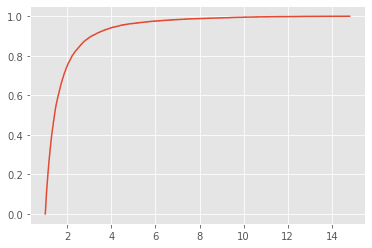

In [28]:
F = build_distribution_function(x_var) 
_ = plt.step(x_var, F)

### Равновероятностная гистограмма

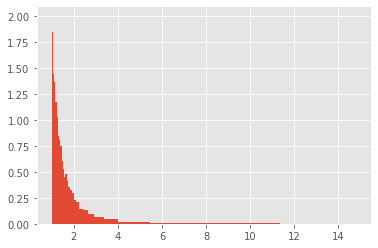

In [29]:
def generate_borders(x_var, segmants):
    n = len(x_var)
    res = [x_var[0]]
    for i in range(n // segments - 1, n - 1, n // segments):
        res.append((x_var[i] + x_var[i + 1]) / 2)
    res.append(x_var[-1])
    return res

borders_eq = generate_borders(x_var, segments)

vals_int, bins_int, patches_int = plt.hist(x_var, bins=borders_eq, density=True)

### Точечная оценка матожидания

In [30]:
m_p = expectation(x_var)
m_p

1.8825833303805672

### Точечная оценка дисперсии

In [31]:
d_p = dispersion(x_var)
print(d_p)

1.9004327738104836


### Интервальная оценка матожидания

In [32]:
import scipy.stats

laplace = [(x, scipy.stats.norm.cdf(x) - 0.5) for x in np.arange(0, 5, 0.01)]

def find_x_laplace(u):
    good_x = 0
    min_d = 10
    for x, y in laplace:
        if abs(u - y) < min_d:
            min_d = abs(u - y)
            good_x = x
    return good_x

def get_interval(s, val, n):
    return s * find_x_laplace(val) / np.sqrt(n)

In [33]:
alpha_e = 0.05
laplace_e = (1 - alpha_e)

interval_len = get_interval(np.sqrt(d_p), laplace_e, n)

print('Interval for E(x) with alpha = {} is ({}, {})'.format(alpha_e, m_p - interval_len, m_p + interval_len))

Interval for E(x) with alpha = 0.05 is (1.8136516389661752, 1.9515150217949593)


### Интервальная оценка дисперсии

In [34]:
def get_dispersion_intervals(s, alpha, n):
    l = s * (n - 1) / chi2.ppf(1 - alpha / 2, n - 1)
    r = s * (n - 1) / chi2.ppf(alpha / 2, n - 1)
    return l, r

def get_dispersion_intervals_known(s, alpha, n):
    l = s * n / chi2.ppf(1 - alpha / 2, n)
    r = s * n / chi2.ppf(alpha / 2, n)
    return l, r 

def get_dispersion_interval(x_var, alpha):
    m_p = expectation(x_var)
    d_p = dispersion(x_var)
    
    return get_dispersion_intervals(d_p, alpha, n)

In [35]:
print(d_p)
print(get_dispersion_interval(x_var, 0.05))

1.9004327738104836
(1.848730788104019, 1.954344846457372)


### Проверим критерий согласия Пирсона

In [73]:
import math
par
# distribution function
def get_F(x0, alpha):
    def F(x):
        return 1 - math.pow(x0 / x, alpha)
    
    return F

def pearson_chi(bins, vals, F, n):
    chi = 0
    for i in range(len(bins) - 1):
        if not vals[i]: continue
            
        l = bins[i]
        r = bins[i + 1]
        pi_s = F(r) - F(l)
        pi = vals[i]
        chi += (pi - pi_s)**2 / pi_s
    
    return chi * n

In [74]:
chi_sqr = pearson_chi(bins, vals, get_F(x0, alpha), n)
table_pearson = chi2.ppf(0.05, len(bins))

print('Experimental chi square: {cs}, Table chi square: {ts}'.format(cs=chi_sqr, ts=table_pearson))

if chi_sqr < table_pearson:
    print('Good')

Experimental chi square: 22.978945073960023, Table chi square: 24.07494255667991
Good
